In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [93]:
# invest s&p500 info tech index
ticker = 'ETF5IT.JO'
stock = yf.Ticker(ticker)
df = stock.history(period= '5y')/100

In [94]:
def yang_zhang_volatility(df):
    # Overnight (Close-to-Open) returns
    overnight_returns = np.log(df['Open'] / df['Close'].shift(1)).dropna()
    var_overnight = overnight_returns.var(ddof=1)

    # Intraday (Open-to-Close) returns
    intraday_returns = np.log(df['Close'] / df['Open']).dropna()
    var_intraday = intraday_returns.var(ddof=1)

    # Rogers-Satchell volatility
    log_hi_open = np.log(df['High'] / df['Open'])
    log_hi_close = np.log(df['High'] / df['Close'])
    log_lo_open = np.log(df['Low'] / df['Open'])
    log_lo_close = np.log(df['Low'] / df['Close'])
    rs_terms = log_hi_open * log_hi_close + log_lo_open * log_lo_close
    var_rs = rs_terms.mean()

    # Rolling window
    window = 10
    k = 0.34 / (1.34 + (window + 1) / (window - 1))

    sigma_oc = intraday_returns.rolling(window).var()
    sigma_co = overnight_returns.rolling(window).var()
    sigma_rs = rs_terms.rolling(window).mean()

    # Yang-Zhang variance
    yz_var = sigma_co + k * sigma_oc + (1 - k) * sigma_rs
    yz_vol = np.sqrt(yz_var)

    return round(yz_vol,6)


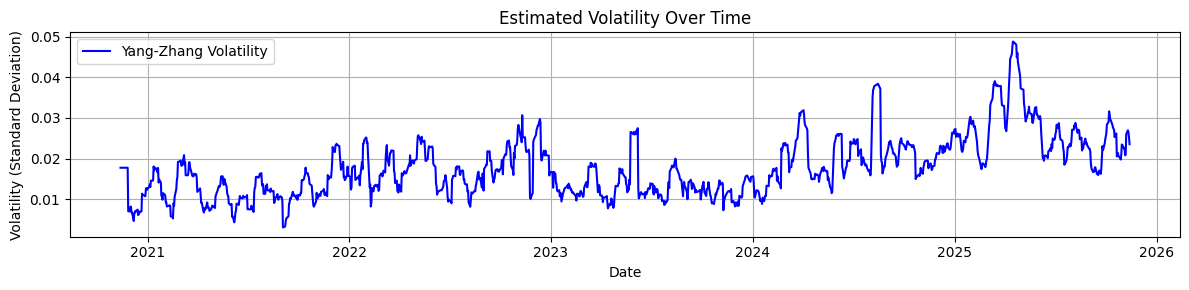

In [95]:
df['Volatility'] = yang_zhang_volatility(df)
df.fillna(df['Volatility'].mean(), inplace = True)
plt.figure(figsize=(12, 3))
plt.plot(df.index, df['Volatility'], label="Yang-Zhang Volatility", color="blue")
plt.title("Estimated Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility (Standard Deviation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
price = df['Open'].iloc[0]
scale_factor = 2.5
def GBM(price,scale_factor):
    estimates = [price]
    for i in range(len(df)-1):
        s0 =  estimates[0+i]
        mu = df['Close'].pct_change().mean()
        sigma = yang_zhang_volatility(df).mean()*scale_factor
        T = 1.0
        N = 252
        paths = 1000
        np.random.seed(42)
        dt = T / N  # Time step
        # Generate standard normal random variables (Wiener process increments)
        dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(N, paths))


        # dS/S = mu*dt + sigma*dW -> S_t+dt = S_t * exp((mu - 0.5 * sigma**2)*dt + sigma*dW)
        daily_factors = np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dW)

        # Prepend a row of initial prices (1s for cumulative product, then multiplied by s0)
        stacked = np.vstack([np.ones(paths) * s0, daily_factors])

        # Calculate the cumulative product to get the price paths
        price_paths = stacked.cumprod(axis=0)
        price_paths = np.mean(price_paths)
        estimates.append(round(price_paths, 2))
    return estimates

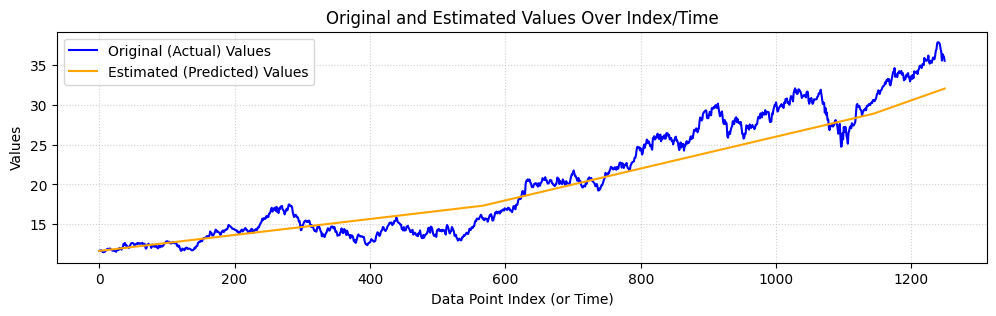

In [97]:
df['Estimate'] = GBM(price,scale_factor)
y_true = df['Close']
y_pred = df['Estimate']
x_axis_labels = np.arange(0, len(df))
plt.figure(figsize=(12, 3))

plt.plot(x_axis_labels, y_true, label='Original (Actual) Values', color='blue')
plt.plot(x_axis_labels, y_pred, label='Estimated (Predicted) Values', color='orange')
plt.title('Original and Estimated Values Over Index/Time')
plt.xlabel('Data Point Index (or Time)')
plt.ylabel('Values')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()
df['Error']= (df['Close'] - df['Estimate'])/df['Close']

In [104]:
results = []
for i in range(6):
  date_str = f'202{i}-11-12'
  date_to_check = pd.Timestamp(date_str).tz_localize(df.index.tz)
  result = df[['Close','Estimate','Error']].asof(date_to_check)
  result.name = date_to_check # Assign the date as the name of the series for better indexing later
  results.append(result)

# Concatenate all results into a DataFrame
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

display(results_df)

,Close,Estimate,Error
2021-11-12 00:00:00+02:00,16.026600,14.15,0.117093
2022-11-12 00:00:00+02:00,14.334960,16.66,-0.162194
2023-11-12 00:00:00+02:00,21.463999,20.96,0.023481
2024-11-12 00:00:00+02:00,30.010000,25.96,0.134955
2025-11-12 00:00:00+02:00,36.020000,32.01,0.111327


In [99]:
results_df['Error'].mean()

np.float64(0.01463643148637235)

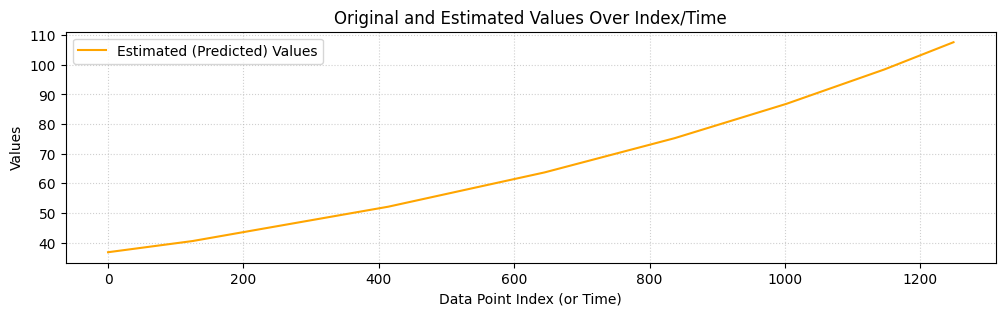

In [100]:
price = df['Open'].iloc[-1]
scale_factor = 2.5
df['Predict'] = GBM(price,scale_factor)
y_true = df['Close']
y_pred = df['Predict']
x_axis_labels = np.arange(0, len(df))
plt.figure(figsize=(12, 3))
plt.plot(x_axis_labels, y_pred, label='Estimated (Predicted) Values', color='orange')
plt.title('Original and Estimated Values Over Index/Time')
plt.xlabel('Data Point Index (or Time)')
plt.ylabel('Values')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


In [101]:
results = [# current price
df['Close'].iloc[-1]]
current_year = df.index[-1].year
for i in range(int(len(df)/252)):
  result = df['Predict'].iloc[252*i]
  results.append(result)
result_df = pd.DataFrame(results)
years = [current_year + i for i in range(len(results))]
result_df.index = years
result_df.index.name = 'Year'
result_df['Error'] = results_df['Error'].mean()
display(result_df)

,0,Error
Year,,
2025,35.53,0.014636
2026,36.74,0.014636
2027,45.60,0.014636
2028,56.61,0.014636
2029,70.35,0.014636


In [102]:
df[['Close','Estimate','Predict']].pct_change().mean()

,0
Close,0.001007
Estimate,0.000810
Predict,0.000861
